In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

import datetime
import math
import calendar

# Thanks for providing this in the forum
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe_xg(yhat, y):
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

In [4]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
store = pd.read_csv('../data/store.csv')

train.shape, test.shape, store.shape

((1017209, 9), (41088, 8), (1115, 10))

In [5]:
train.Store.nunique() == store.Store.nunique()

True

In [6]:
df = train.merge(store, how='left', left_on=train.Store, right_on=store.Store)
df.drop(['key_0', 'Store_y'], axis=1, inplace=True)
df = df.rename(columns={'Store_x':'Store'})
df.shape

(1017209, 18)

In [ ]:
Understanding data

In [7]:
round(df.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
Store,1017209.0,558.43,321.91,1.0,280.0,558.0,838.0,1115.0
DayOfWeek,1017209.0,4.00,2.00,1.0,2.0,4.0,6.0,7.0
Sales,1017209.0,5773.82,3849.93,0.0,3727.0,5744.0,7856.0,41551.0
Customers,1017209.0,633.15,464.41,0.0,405.0,609.0,837.0,7388.0
Open,1017209.0,0.83,0.38,0.0,1.0,1.0,1.0,1.0
Promo,1017209.0,0.38,0.49,0.0,0.0,0.0,1.0,1.0
SchoolHoliday,1017209.0,0.18,0.38,0.0,0.0,0.0,0.0,1.0
CompetitionDistance,1014567.0,5430.09,7715.32,20.0,710.0,2330.0,6890.0,75860.0
CompetitionOpenSinceMonth,693861.0,7.22,3.21,1.0,4.0,8.0,10.0,12.0
CompetitionOpenSinceYear,693861.0,2008.69,5.99,1900.0,2006.0,2010.0,2013.0,2015.0


In [8]:
train.duplicated().sum(), test.duplicated().sum()

(0, 0)

In [9]:
train.isnull().sum().sum(), test.isnull().sum().sum()

(0, 11)

In [ ]:
EDA

In [10]:
print("Training data starts from: {}".format(train.Date.min()))
print("Training data end on: {}".format(train.Date.max()))
print()
print("Testing data starts from: {}".format(test.Date.min()))
print("Testing data end on: {}".format(test.Date.max()))

Training data starts from: 2013-01-01
Training data end on: 2015-07-31

Testing data starts from: 2015-08-01
Testing data end on: 2015-09-17


In [11]:
df.Date = pd.to_datetime(df.Date)
df['Day'] = df.Date.dt.day
df['Month'] = df.Date.dt.month
df['Year'] = df.Date.dt.year

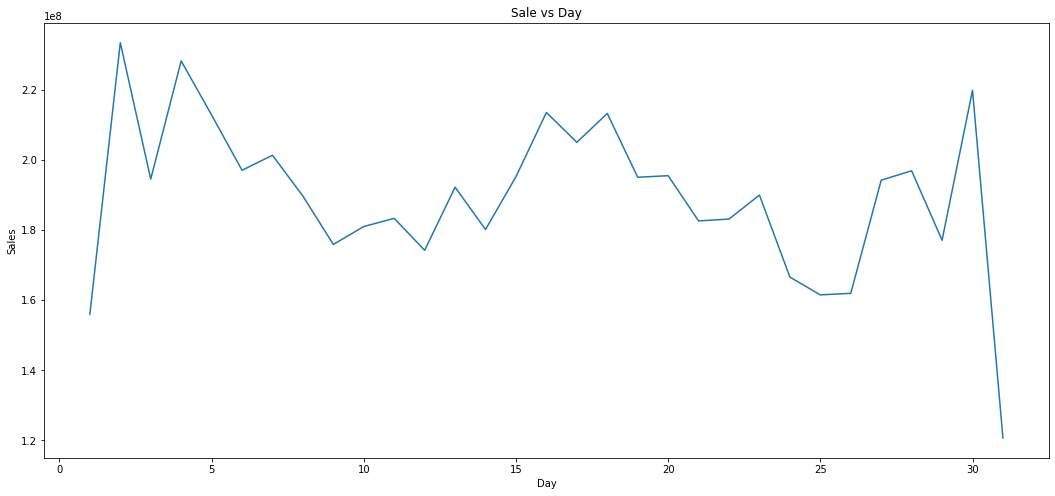

In [12]:
plt.figure(figsize=(18,8))
plt.plot(df.groupby(df.Day).sum().Sales)
plt.title("Sale vs Day")
plt.xlabel('Day')
plt.ylabel('Sales')
plt.show()

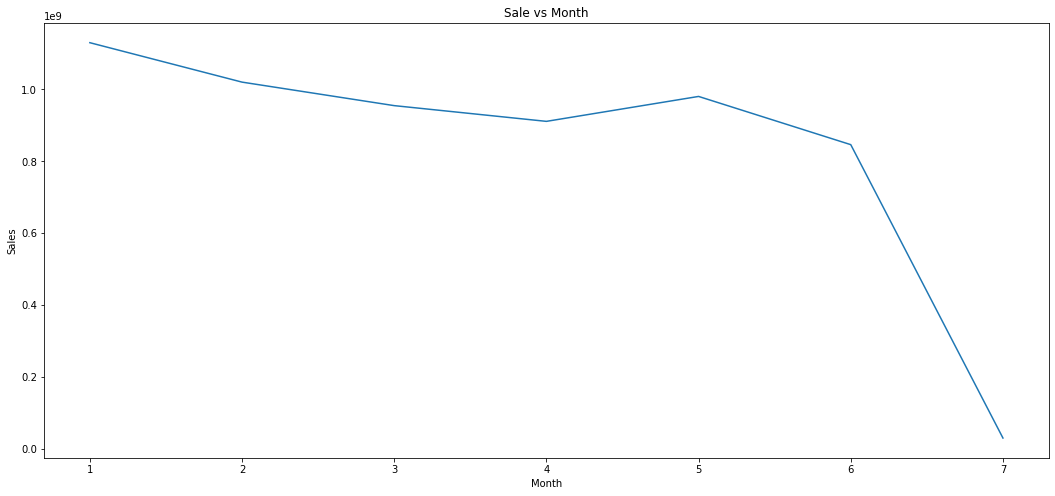

In [13]:
plt.figure(figsize=(18,8))
plt.plot(df.groupby(df.DayOfWeek).sum().Sales)
plt.title("Sale vs Month")
plt.xlabel('Month')
plt.ylabel('Sales')
plt.show()

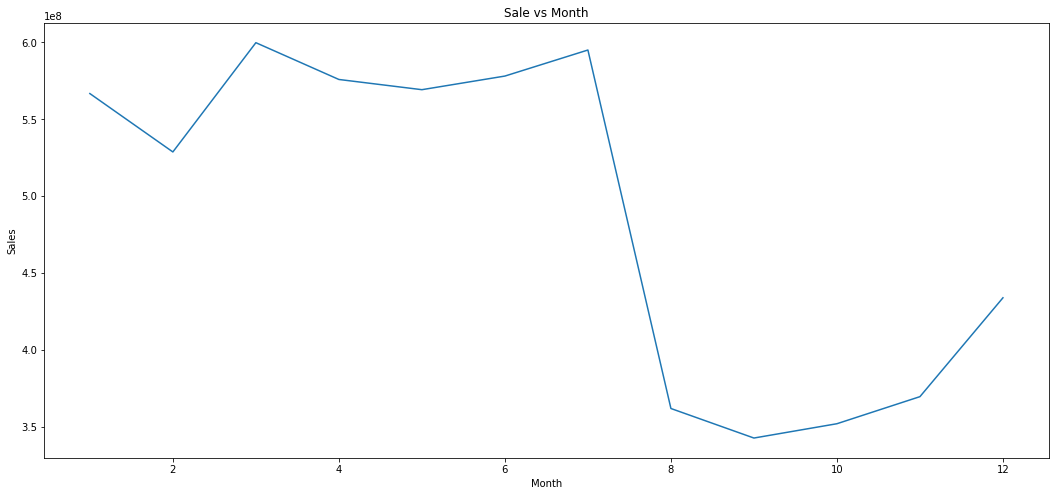

In [14]:
plt.figure(figsize=(18,8))
plt.plot(df.groupby(df.Month).sum().Sales)
plt.title("Sale vs Month")
plt.xlabel('Month')
plt.ylabel('Sales')
plt.show()

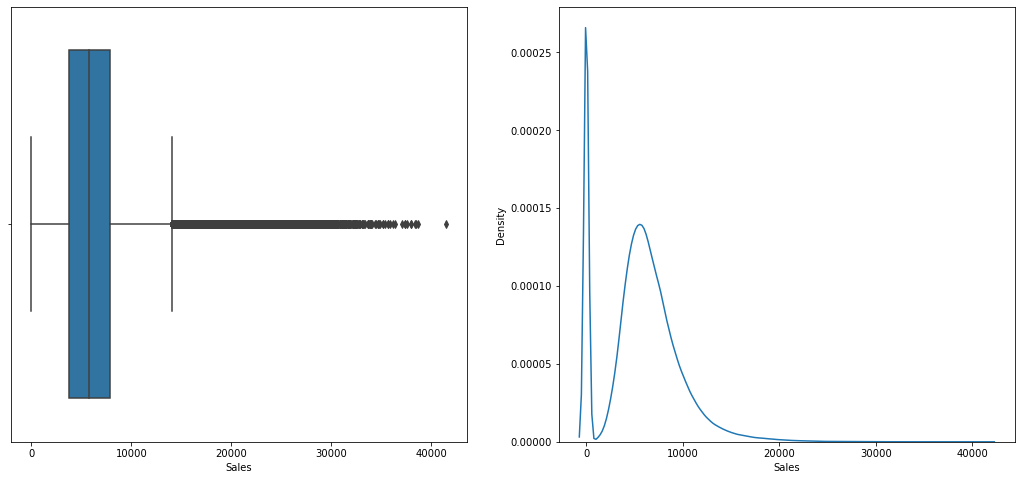

In [15]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
sns.boxplot(train.Sales, ax=ax1)
sns.kdeplot(train.Sales, ax=ax2)
plt.show()

In [16]:
df[df.Open==0].Sales.value_counts()

0    172817
Name: Sales, dtype: int64

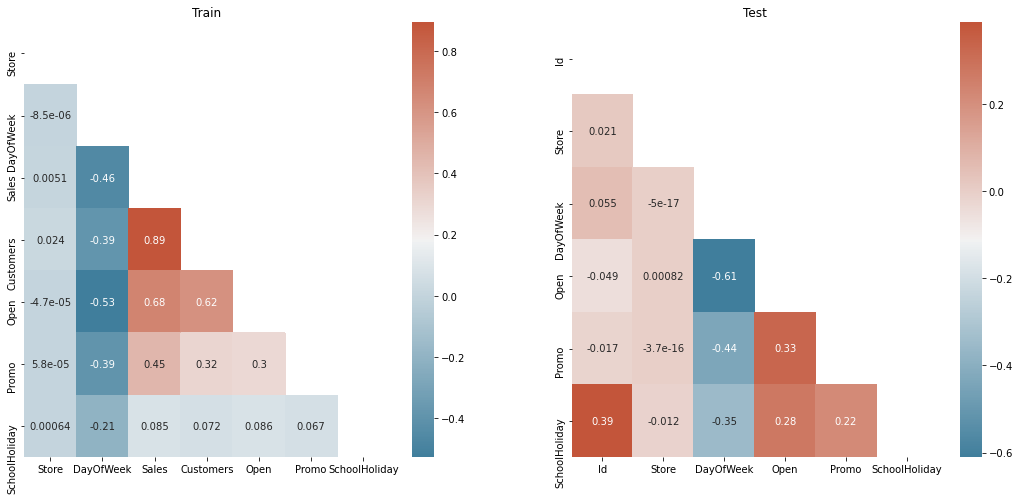

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(train.corr(), mask=mask, cmap=cmap, annot=True, ax=ax1)
ax1.set_title('Train')
corr = test.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(test.corr(), mask=mask, cmap=cmap, annot=True, ax=ax2)
ax2.set_title('Test')
plt.show()

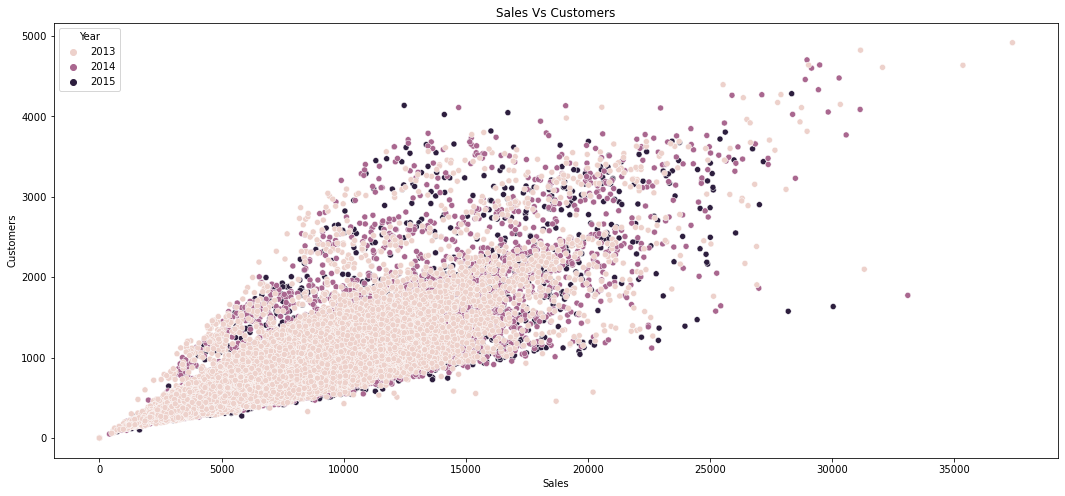

In [18]:
plt.figure(figsize=(18,8))
temp_df = df.sample(100000)
sns.scatterplot(temp_df.Sales, temp_df.Customers, hue=df.Year)
plt.title("Sales Vs Customers")
plt.show()

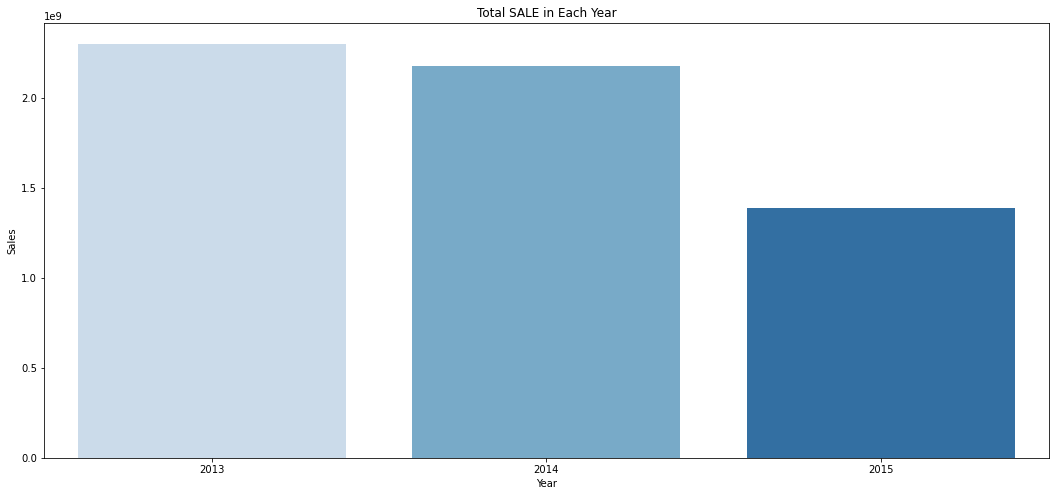

In [19]:
plt.figure(figsize=(18,8))
temp_df = df.groupby(df.Year).sum()
sns.barplot(temp_df.index, temp_df.Sales, palette='Blues')
plt.title("Total SALE in Each Year")
plt.xlabel('Year')
plt.ylabel('Sales')
plt.show()

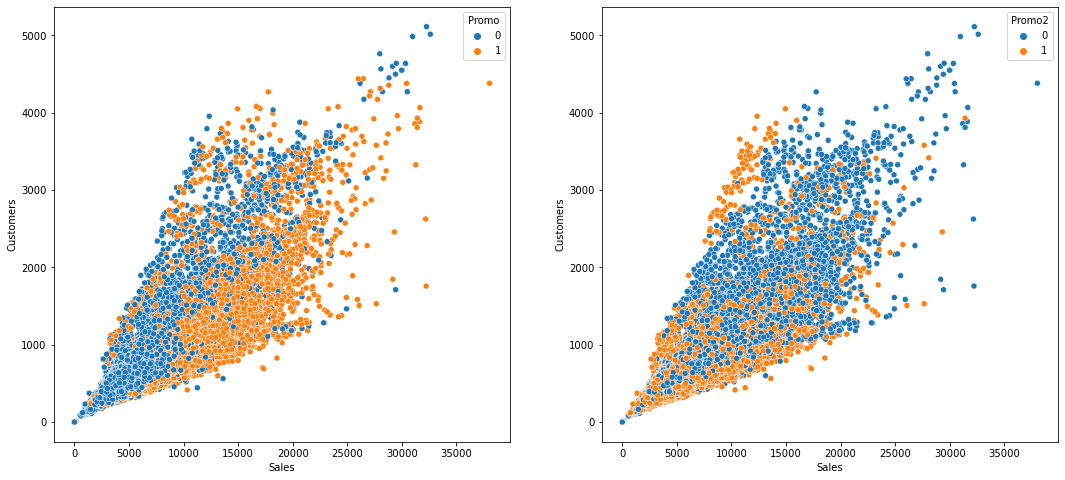

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
temp_df = df.sample(100000)
sns.scatterplot(temp_df.Sales, temp_df.Customers, hue=df.Promo, ax=ax1)
sns.scatterplot(temp_df.Sales, temp_df.Customers, hue=df.Promo2, ax=ax2)
plt.show()

In [21]:
df.groupby(df.Promo).Sales.mean()[1] > df.groupby(df.Promo2).Sales.mean()[1] #1 means store participated

True

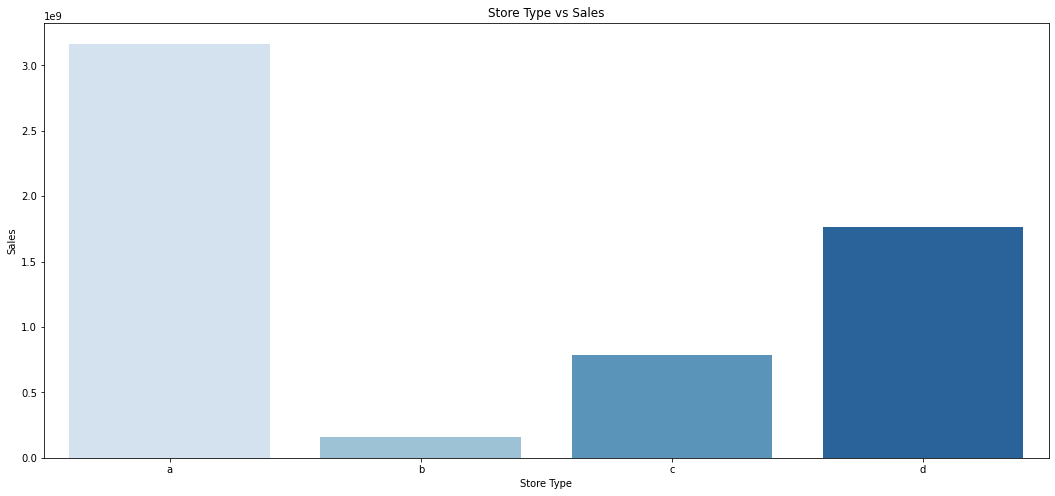

In [22]:
plt.figure(figsize=(18,8))
temp_df = df.groupby(df.StoreType).sum()
sns.barplot(temp_df.index, temp_df.Sales, palette='Blues')
plt.title("Store Type vs Sales")
plt.xlabel('Store Type')
plt.ylabel('Sales')
plt.show()

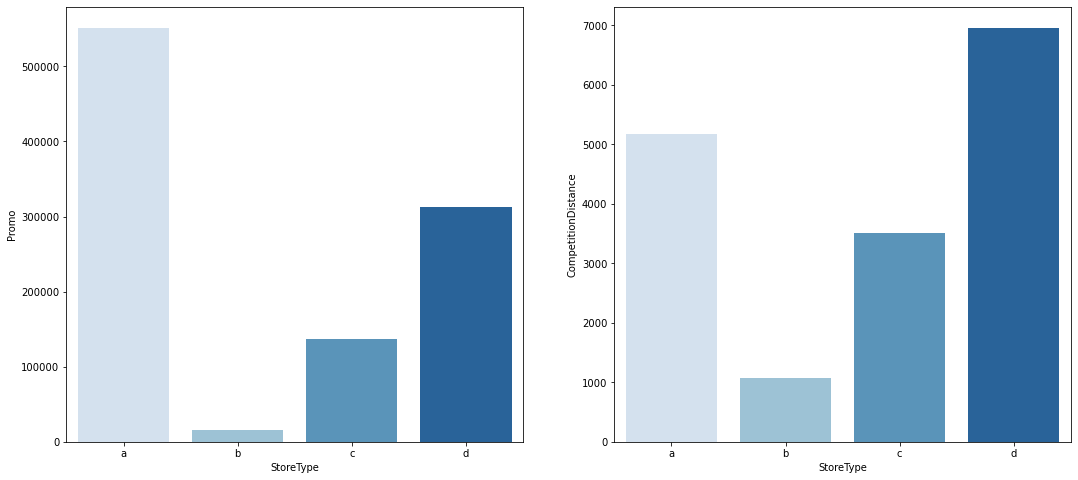

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
temp_df = df.groupby(df.StoreType).count()
sns.barplot(temp_df.index, temp_df['Promo'], ax=ax1, palette='Blues')
temp_df = df.groupby(df.StoreType).mean()
sns.barplot(temp_df.index, temp_df['CompetitionDistance'], ax=ax2, palette='Blues')
plt.show()

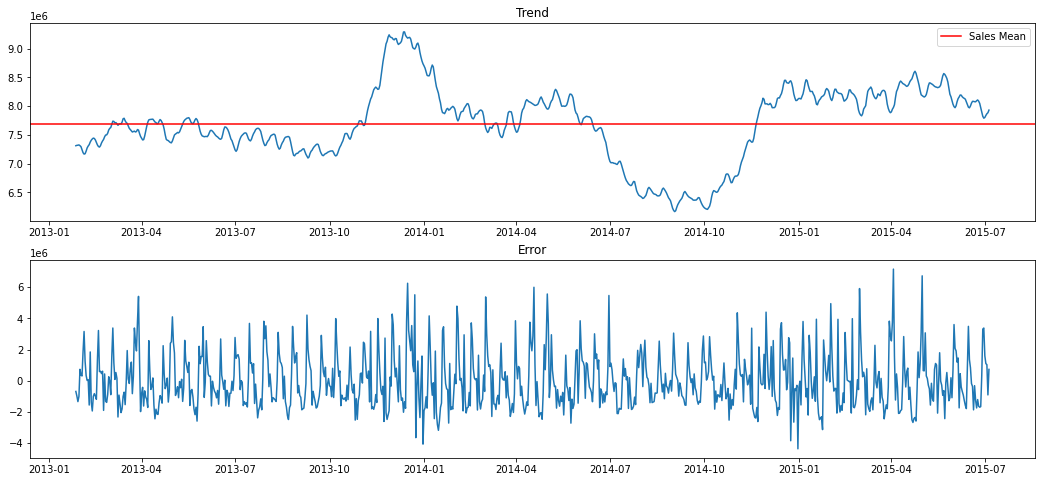

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose
temp_df = train.copy()
temp_df.Date = pd.to_datetime(temp_df.Date)
temp_df.index = temp_df.Date
temp_df.Sales = temp_df.Sales.apply(lambda x: None if x == 0 else x)
temp_df.Sales = temp_df.Sales.fillna(method='ffill').fillna(method='bfill')
temp_df = temp_df[['Sales']]
temp_df = temp_df.groupby(temp_df.index).sum()
result = seasonal_decompose(temp_df, model='additive', freq=52)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(18,8))
ax1.plot(result.trend)
ax1.axhline(y = temp_df.Sales.mean(), color = 'r', linestyle = '-', label='Sales Mean')
ax1.set_title("Trend")
ax2.plot(result.resid)
ax2.set_title("Error")
ax1.legend()
plt.show()